# Predicting Olympic Athlete's Sports

Andrew Whitman

## Context

This data set contains basic data on Olympic athletes from 1896 through 2016.   This data was procurred from Kaggle.  It was scraped from www.sports-reference.com by Randi Griffin in May of 2018. 

## Content

The file athlete_events.csv contains 271116 rows and 15 columns. Each row corresponds to an individual athlete competing in an individual Olympic event. The columns are:

- ID: Unique number for each athlete
- Name: Athlete's name
- Sex: M or F
- Age: Integer
- Height: In centimeters
- Weight: In kilograms
- Team: Team name
- NOC: National Olympic Committee 3-letter code
- Games: Year and season
- Year: Integer
- Season: Summer or Winter
- City: Host city
- Sport: Sport
- Event: Event
- Medal: Gold, Silver, Bronze, or NA

## Inspiration

This dataset provided me an opportunity to work on creating classification models with data I'm passionate about.  As an avid olympic fan, I thought it would be fun to come up with a way to predict the sport category of an athlete based on some of their features.  I will be working with pycaret to create, tune, and finalize my model.  


In [1]:
#import packages

from pycaret.classification import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Global Figure Settings for notebook ----

global_fig_settings = {"renderer": "notebook", "width": 1000, "height": 600}

## Processing and Cleaning Data

To process and clean the data I completed the following:
- check dtypes
- drop unnecessary columns
- filter to year 1980 - 2016
- drop na values
- check statistics

In [3]:
# Read files to pandas database

athletes = pd.read_csv('Desktop/Datasets/Olympic Athletes/athlete_events.csv')
countries = pd.read_csv('Desktop/Datasets/Olympic Athletes/noc_regions.csv')

athletes.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
#Check data types

athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


There are a few columns that will not be used in my analysis so we will remove them from our dataste.

In [5]:
# Drop City and Medal columns

athletes.drop(['City', 'Medal'], axis = 1, inplace=True)

In [6]:
# Check for null values

athletes.isna().sum()

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
Sport         0
Event         0
dtype: int64

There is large number of null values in Age, Height, and Weight.  As these will be used to create our model, we need to either delete or fill them.  I believe most of these must come from the earlier Olympic Years.  Due to that I'm going to filter our data to only contain athletes from the year 1980 and on.  This was the first year that there was more than 35 events in the winter olympics and 200 events in the summer olympics.

In [7]:
since_1980 = athletes['Year'] >= 1980
athletes = athletes[since_1980]
athletes.isna().sum()

ID           0
Name         0
Sex          0
Age        572
Height    8147
Weight    8590
Team         0
NOC          0
Games        0
Year         0
Season       0
Sport        0
Event        0
dtype: int64

This significantly reduced the number of values.  To take care of the rest we will first get rid of any duplicate names who have been in multiple olympic games.  

In [8]:
# Drop duplicates and check null values
athletes.drop_duplicates('Name', inplace=True)
athletes.isna().sum()

ID           0
Name         0
Sex          0
Age        447
Height    5339
Weight    5549
Team         0
NOC          0
Games        0
Year         0
Season       0
Sport        0
Event        0
dtype: int64

We will drop any other null values from our data set.

In [9]:
athletes.dropna(subset=['Age', 'Height', 'Weight'], inplace=True)


In [10]:
athletes.isna().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
Sport     0
Event     0
dtype: int64

In [11]:
# Check length of new data frame

len(athletes)

71982

Removing null values reduced our the size of our dataset to 71982.  While a significant reduction, it should still leaves us with enough observations to create a strong classification model.  Next we will check the statistics of our dataset.

In [12]:
athletes.describe().round(2)

,ID,Age,Height,Weight,Year
count,71982.00,71982.00,71982.00,71982.00,71982.00
mean,68398.47,24.10,176.60,72.06,1999.07
std,39199.32,4.67,10.72,15.19,11.22
min,1.00,12.00,127.00,25.00,1980.00
25%,34684.50,21.00,169.00,61.00,1988.00
50%,68756.00,23.00,177.00,70.00,2000.00
75%,102073.75,26.00,184.00,81.00,2008.00
max,135571.00,70.00,226.00,214.00,2016.00


The minimum age of 12 and maximum age of 70 looked a bit questionable so I did some quick research.  I found that the youngest olympian ever was Dimitrios Loundras of Greece (10) and the oldest ever was Oscar Swahn of Sweden (72).  We won't do anything to remove that data.

The following features are what I want to use to predict the sport that an athlete will play: Sex, Age, Height, Weight, and BMI.  We will drop all other columns and convert the remaining columns into categorical data.  We will use the quantiles from our statistics to break up the numerical data into bins.

In [13]:
# Drop unused columns and reset index

athletes.drop(['ID', 'Name', 'Team', 'Games', 'Year', 'Event', 'NOC'], axis=1, inplace=True)
athletes.reset_index(drop=True, inplace=True)
athletes.head()

,Sex,Age,Height,Weight,Season,Sport
0,M,24.0,180.0,80.0,Summer,Basketball
1,M,23.0,170.0,60.0,Summer,Judo
2,F,21.0,185.0,82.0,Winter,Speed Skating
3,M,31.0,188.0,75.0,Winter,Cross Country Skiing
4,M,31.0,183.0,72.0,Winter,Cross Country Skiing


We will add a BMI (Body Mass Index) column to our dataframe.  This will take into account how healthy the body composition of the athlete is.  The BMI is calculated by diving the athlete's weight in kilograms by the square of their height in meters.  

In [14]:
# Add bmi column
athletes['bmi'] = (athletes['Weight']/((athletes['Height']/100)**2)).round(1)
athletes.head()

,Sex,Age,Height,Weight,Season,Sport,bmi
0,M,24.0,180.0,80.0,Summer,Basketball,24.7
1,M,23.0,170.0,60.0,Summer,Judo,20.8
2,F,21.0,185.0,82.0,Winter,Speed Skating,24.0
3,M,31.0,188.0,75.0,Winter,Cross Country Skiing,21.2
4,M,31.0,183.0,72.0,Winter,Cross Country Skiing,21.5


In [15]:
def cont_to_categ(data, column, bins, labels):
    """
    Converts a continuous dtype into categorical using bins
            
            Parameters: 
                data: pandas dataframe
                column (string): column name
                bins (list): list of start and end of each bin
                labels (list): list of labels for each bin
    """

    data[column] = pd.cut(x=data[column],
                         bins=bins,
                         labels=labels)
    return


# Convert age to categorical
cont_to_categ(athletes, 'Age', [0, 16, 19, 23, 26, 30, 35, 45, 60, 99], ['Very Young', 'Young', 'Young Adult', 'Adult',
                             'Late Twenties', 'Early Thirties', 'Middle-Aged', 'Older', 'Oldest'])

# Convert height to categorical
cont_to_categ(athletes, 'Height', [0, 160, 170, 180, 190, 205, 230], ['Very Short', 'Short', 'Average',
                             'Tall', 'Very Tall', 'Extremely Tall'])

# Convert weight to categorical
cont_to_categ(athletes, 'Weight', [0, 50, 60, 70, 80, 90, 100, 120, 150, 230], ['Very Small', 'Small', 'Below-Average', 
                             'Average', 'Above-Average', 'Large', 'Very Large', 'Huge', 'Giant'])

# Convert bmi to categorical
cont_to_categ(athletes, 'bmi', [0, 18.5, 25, 30, 35, 40, 100], ['Underweight', 'Healthy', 'Overweight',
                             'Very Overweight', 'Obese', 'Severely Obese'])

athletes.head()

,Sex,Age,Height,Weight,Season,Sport,bmi
0,M,Adult,Average,Average,Summer,Basketball,Healthy
1,M,Young Adult,Short,Small,Summer,Judo,Healthy
2,F,Young Adult,Tall,Above-Average,Winter,Speed Skating,Healthy
3,M,Early Thirties,Tall,Average,Winter,Cross Country Skiing,Healthy
4,M,Early Thirties,Tall,Average,Winter,Cross Country Skiing,Healthy


Currently, there are too many sports to create a model that will have any semblance of accuracy.  To reduce the sports, we will work only with the athletes competing during the summer season.  

In [16]:
# Drop athletes from winter season

athletes = athletes[athletes.Season == 'Summer']
athletes.drop('Season', axis=1, inplace=True)

After dropping the winter sports, there is still too many sports (25) for us to create an accurate model.  We will group the sports into 4 categories to make it possible to accurately model the data.  The categories will be 'Active', 'Minimally Active', 'Fighting', and 'Gymnastics'.

In [17]:
# Map sports to 4 categories

sport_group_map = {'Archery': 'Minimally Active', 'Athletics': 'Active', 'Badminton': 'Active', 
                   'Baseball': 'Active', 'Basketball': 'Active',
                   'Beach Volleyball': 'Active', 'Boxing': 'Fighting', 'Canoeing': 'Active',
                   'Cycling': 'Active', 'Diving': 'Minimally Active', 'Equestrianism': 'Minimally Active',
                   'Fencing': 'Minimally Active', 'Football': 'Active', 'Golf': 'Minimally Active', 
                   'Gymnastics': 'Gymnastics', 'Handball': 'Active', 'Hockey': 'Active',
                   'Judo': 'Fighting', 'Modern Pentathlon': 'Active', 'Rhythmic Gymnastics': 'Gymnastics', 
                   'Rowing': 'Active', 'Rugby Sevens': 'Active', 'Sailing': 'Active', 
                   'Shooting': 'Minimally Active', 'Softball': 'Active', 'Swimming': 'Active',
                   'Synchronized Swimming': 'Active', 'Table Tennis': 'Active', 'Taekwondo': 'Fighting',
                   'Tennis': 'Active', 'Trampolining': 'Gymnastics', 'Triathlon': 'Active', 'Volleyball': 'Active',
                   'Water Polo': 'Active', 'Weightlifting': 'Fighting', 'Wrestling': 'Fighting'
                  }

athletes['Sport Category'] = athletes['Sport'].map(sport_group_map)
athletes.drop('Sport', axis=1, inplace=True)
athletes.head()

,Sex,Age,Height,Weight,bmi,Sport Category
0,M,Adult,Average,Average,Healthy,Active
1,M,Young Adult,Short,Small,Healthy,Fighting
7,M,Early Thirties,Average,Below-Average,Healthy,Active
8,F,Late Twenties,Very Short,Small,Healthy,Active
11,M,Early Thirties,Tall,Huge,Obese,Active


## Create model and predict

We will take a random sample of 90% of our data to train our model.  The remaining 10% will be used to test our model after its finalized.  We will compare three models: logistic regression, decision tree, and random forest.  

In [18]:
# Seperate data for modeling and unseen data for predictions

data = athletes.sample(frac=0.9, random_state=786)
data_unseen = athletes.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (54716, 6)
Unseen Data For Predictions: (6080, 6)


In [19]:
exp = setup(data = data, target = 'Sport Category', session_id=123) 

,Description,Value
0,Session id,123
1,Target,Sport Category
2,Target type,Multiclass
3,Target mapping,"Active: 0, Fighting: 1, Gymnastics: 2, Minimally Active: 3"
4,Original data shape,"(54716, 6)"
5,Transformed data shape,"(54716, 6)"
6,Transformed train set shape,"(38301, 6)"
7,Transformed test set shape,"(16415, 6)"
8,Ordinal features,1
9,Categorical features,5


In [20]:
# Take best model from logreg, decision tree, and random forest

best = exp.compare_models(include=('lr', 'dt', 'rf'))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7465,0.7650,0.7465,0.7201,0.6878,0.2158,0.2745,0.6250
rf,Random Forest Classifier,0.6627,0.6622,0.6627,0.5809,0.6190,0.1142,0.1201,0.3940
dt,Decision Tree Classifier,0.6459,0.5657,0.6459,0.5858,0.6128,0.1285,0.1329,0.2290


In [21]:
# Tune model

tuned_lr = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7499,0.7663,0.7499,0.7356,0.6904,0.2188,0.2846
1,0.7504,0.7594,0.7504,0.7272,0.6936,0.2294,0.2899
2,0.7454,0.7604,0.7454,0.7128,0.6865,0.2155,0.2719
3,0.7473,0.7601,0.7473,0.7259,0.6888,0.2167,0.2760
4,0.7376,0.7566,0.7376,0.6968,0.6807,0.1992,0.2459
5,0.7452,0.7639,0.7452,0.7192,0.6841,0.2048,0.2657
6,0.7507,0.7751,0.7507,0.7200,0.6944,0.2373,0.2944
7,0.7415,0.7682,0.7415,0.7087,0.6805,0.1985,0.2535
8,0.7530,0.7798,0.7530,0.7338,0.6965,0.2369,0.3004


Fitting 10 folds for each of 10 candidates, totalling 100 fits


We will get the details of exactly how our model did predicting each category using a confusion matrix.

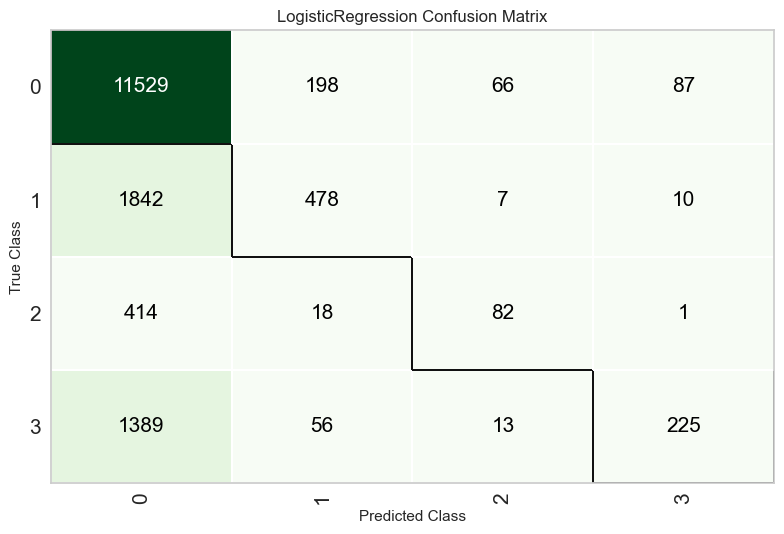

In [22]:
plot_model(tuned_lr, plot='confusion_matrix')

In [23]:
# Finalize model

final_lr = finalize_model(tuned_lr)

In [24]:
# Test model on unseen data

unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7512,0.7622,0,0,0,0.2430,0.3061


,Sex,Age,Height,Weight,bmi,Sport Category,prediction_label,prediction_score
0,0.0,0.421527,0.714571,0.585082,0.941748,Fighting,Fighting,0.5508
1,1.0,0.751467,0.329648,0.450670,0.470207,Minimally Active,Active,0.8360
2,1.0,0.421527,0.329794,0.339916,0.755952,Fighting,Active,0.5519
3,1.0,0.421577,0.524679,0.522804,0.470278,Active,Active,0.7083
4,1.0,0.421577,0.994158,0.522804,0.592823,Active,Fighting,0.8192


## Conclusion

The logistic regression meodel had a 75% accuracy score on our unseen data.  This is a strong score but was greatly helped by the grouping of the sports into 4 categories.  I would be interested to see if we could get more accurate predictions if we added more features.  Specifically, I would be curious to add the region that the athlete is from and see if that helps our model become more accurate.  Overall, I liked pycaret for classification models.  You do need to keep an eye on how pycaret converts your data to categorical.  It will create a category for every unique value and grouping by bins can become very important for continuous data. 